## Analysis of a Stabilization graph
Based on J.S.-Y. Chao *et al.*, *J. Chem. Phys.* **93**, 1125 (1990)

See also M. F. Falcetta *et al.*, *J. Phys. Chem. A* **118**, 7489 (2014) 

Analytic continuation of two roots using a generalized Pade approximant and input data from a crossing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Qt5Agg')
#%matplotlib qt5

In [2]:
#
# if pade.py is not in the current directory, set this path:
#
import sys
sys.path.append('../../Python_libs')
import gen_pade as gpa
import stabtools as st

In [3]:
Angs2Bohr=1.8897259886
au2eV=27.211386027
au2cm=219474.63068
#
#df=pd.read_csv("DVR_stab_plot.csv", delim_whitespace=False)
#df=pd.read_csv("GTO_unc_stab_plot.csv", delim_whitespace=False)
#df=pd.read_csv("GTO_DZ_stab_plot.csv", delim_whitespace=False)
df=pd.read_csv("GTO_TZ_stab_plot.csv", delim_whitespace=False)
df.tail()

,L,z,E1,E2,E3,E4,E5,E6,E7
155,0.733285,1.859748,-7.170453,0.937669,2.937078,3.876867,7.437323,12.848171,19.658801
156,0.731309,1.869811,-7.170453,0.945644,2.944293,3.896012,7.472387,12.899824,19.735561
157,0.729349,1.879874,-7.170453,0.953651,2.951278,3.915364,7.507352,12.951403,19.812274
158,0.727405,1.889937,-7.170453,0.961689,2.958041,3.934914,7.542221,13.002907,19.888941
159,0.725476,1.900000,-7.170453,0.969759,2.964592,3.954651,7.576995,13.054338,19.965564


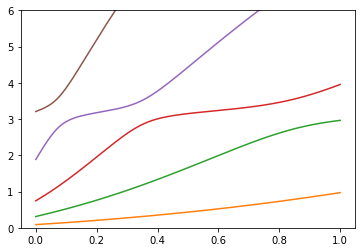

In [4]:
alpha=df.columns[1]
E_labels=df.columns[2:]
zs=df[alpha].values
zmin, zmax = zs[0], zs[-1]
if zmax < zmin:
    zmin, zmax = zmax, zmin
zs=(zs-zmin)/(zmax-zmin)
if True:
    plt.cla()
    for E in E_labels:
        plt.plot(zs, df[E].values, '-')
    plt.ylim(0,6)
    plt.show()

Set the following parameters after inspecting the stabilization plot:
* lroot: the lower root; the 2nd root is lroot+1
* curvature_drop-off: the crossing is defined by the minimum and maximum curvature positions; the  selection range is determined by the drop off of the abs(curvature) 

Center of the crossing at z=0.069182
N = 14 points on each curve


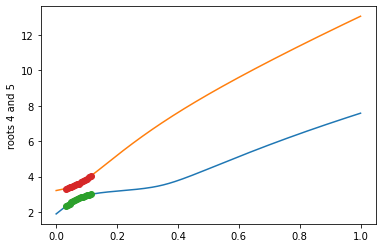

In [5]:
lroot=4
curvature_drop_off=0.5
E_lw=df[E_labels[lroot]].values
E_up=df[E_labels[lroot+1]].values
#success, zc, alps, E1s, E2s = st.crossing(zs, E_lw, E_up, select=-1)
success, zc, alps, E1s, E2s = st.crossing(zs, E_lw, E_up, select=curvature_drop_off)
if not success:
    print('No crossing found.')
    zcs = (zs[alps[0]], zs[alps[1]])
    print('min/max curvature at z=%f and z=%f' % zcs)
    plt.cla()
    plt.plot(zs, E1s, zs, E2s)
    plt.ylabel('curvature '+str(lroot)+' and '+str(lroot+1))
    plt.show()
else:
    print('Center of the crossing at z=%f' % (zc))
    npts = len(alps)
    print('N = %d points on each curve' % (npts))
    plt.cla()
    plt.plot(zs, E_lw, zs, E_up)
    plt.plot(alps, E1s, 'o', alps, E2s, 'o')
    plt.ylabel('roots '+str(lroot)+' and '+str(lroot+1))
    plt.show()

Make one long list of all energies, which requires the L or alpha list twice,
to prepare the fit to a generalized Pade approximant.

In [6]:
LL = list(alps) + list(alps)
Es = list(E1s) + list(E2s)

## Fit to generalized [$n$,$n$,$n$]-Pade approximant.

P*E^2 + Q*E + R = 0
P :
           2
-0.5516 x + 0.4284 x + 0.08176

Q :
         3         2
13.89 x - 4.904 x - 3.569 x - 0.4167

R :
         4      3        2
4.632 x - 44 x + 22.6 x + 6.694 x + 0.4953


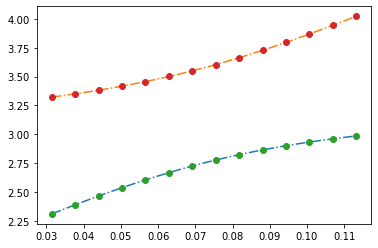

In [7]:
nP, nQ, nR = 2, 3, 4
A, B, C = gpa.genpade2_via_lstsq(nP, nQ, nR, LL, Es, rcond=1e-14)
print('P*E^2 + Q*E + R = 0')
print('P :\n ', A)
print('\nQ :\n ', B)
print('\nR :\n ', C)

#
# compare the input energies and the fitted curves
#
npts=100
Lplots=np.linspace(LL[0],LL[-1],npts)
E1plot=np.zeros(npts)
E2plot=np.zeros(npts)
for i in range(npts):
    E1plot[i]=gpa.E_lower(Lplots[i], A, B, C)
    E2plot[i]=gpa.E_upper(Lplots[i], A, B, C)
plt.cla()
plt.plot(Lplots,E1plot,'-.')
plt.plot(Lplots,E2plot,'-.')
plt.plot(alps,E1s,'o')
plt.plot(alps,E2s,'o')

### Evaluate the Pade approximant in the complex plane. 
* That gives two roots. 
* Plot log(|dE/dL|) for both
* Do a grid search: start from minima in all $n_g$-by-$n_g$ squares  

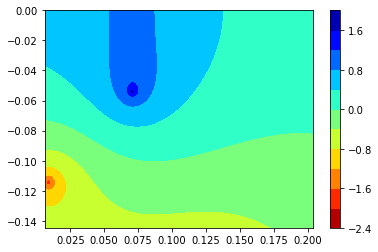

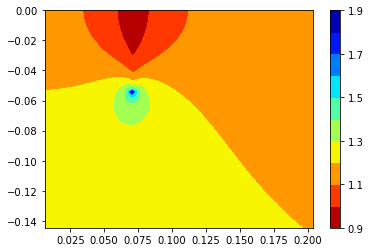

In [8]:
ng=9
npts=ng*ng
rp=0.8 # plus/minus x%
ip=(alps[-1]+alps[0])
Lrs = np.linspace(alps[0]*(1-rp), alps[-1]*(1+rp), npts)
#Lis = np.linspace(0, +ip, npts)
Lis = np.linspace(-ip, 0, npts)
der1 = np.zeros([npts,npts])
der2 = np.zeros([npts,npts])
for r in range(npts):
    for i in range(npts):
        L=Lrs[r]+ 1j*Lis[i]
        rs, ds = gpa.E_and_Ep(L, A, B, C)
        der1[i,r] = np.log10(min(ds))
        der2[i,r] = np.log10(max(ds))

plt.cla()        
plt.figure(1)
plt.contourf(Lrs, Lis, der1, 10, cmap=plt.cm.jet_r)
plt.colorbar()
plt.figure(2)
plt.contourf(Lrs, Lis, der2, 10, cmap=plt.cm.jet_r)
plt.colorbar()
plt.show()

In [9]:
i2 = np.unravel_index(np.argmin(der1, axis=None), der1.shape)
print(i2, der1[i2])

(17, 1) -2.2593285817360127


In [10]:
Econv = []
Lconv = []
for i in range(0,npts,ng):
    for j in range(0,npts,ng):
        square = der1[i:i+ng,j:j+ng]
        i2 = np.unravel_index(np.argmin(square, axis=None), square.shape)
        if square[i2] < 0:
            L_guess=Lrs[i2[0]+i] + 1j*Lis[i2[1]+j]
            conv, Lstar, Estar, der = gpa.GPA_NewtonRaphson(L_guess, (A, B, C), verbose=False)
            if conv:
                Econv.append(Estar)
                Lconv.append(Lstar)

Econv = np.array(Econv)
Lconv = np.array(Lconv)
df=pd.DataFrame({"Er": Econv.real, "Ei": Econv.imag, "Lr": Lconv.real, "Li": Lconv.imag})
df['Er6dig']=np.round(df['Er'],6)
df['Ei6dig']=np.round(df['Ei'],6)
df.drop_duplicates(subset=['Er6dig', 'Ei6dig'], inplace=True)
df[(df['Li']<0)].sort_values(by=['Lr'])

,Er,Ei,Lr,Li,Er6dig,Ei6dig
0,3.191009,-0.185501,0.009074,-0.114209,3.191009,-0.185501
8,3.175656,-0.163405,0.130352,-0.196128,3.175656,-0.163405


Identify and optimize roots by hand

In [25]:
#
#   read-off minima from figure 1
#
L_guess=0.08-1j*0.05  # roots 3/4 n=234
#L_guess=0.18-1j*0.05  # roots 3/4 n=234

roots, ders = gpa.E_and_Ep(L_guess, A, B, C)
for i, r in enumerate(roots):
    print('(%f, %f)  d=%f' % (r.real, r.imag, ders[i]))
i_root=np.argmin(ders)
Ecurr=roots[i_root]
step = gpa.EpoEpp(Ecurr, L_guess, A, B, C)
print('Newton step for root %d: (%f, %f)' % (i_root, step.real, step.imag))

(4.000649, -0.051271)  d=0.269108
(3.301534, -0.792857)  d=16.867657
Newton step for root 0: (-0.002640, -0.004774)


In [26]:
conv, Lstar, Estar, der = gpa.GPA_NewtonRaphson(L_guess, (A, B, C))
if conv:
    print("  L_star = (%.6f, %.6f)" % (Lstar.real, Lstar.imag))
    print('  derivative = %.3e' % (der))
    print("  Er = %.6f,  Ei = %.6f" % (Estar.real, Estar.imag))
else:
    print("No convergence in 20 steps.")

Newton Raphson steps:
 step    z_curr                   E_curr
-----------------------------------------------------
  0   (0.0826404, -0.0452260)   (3.9999496, -0.0511353)
  1   (0.0825395, -0.0454272)   (3.9999482, -0.0511352)
  2   (0.0825394, -0.0454277)   (3.9999482, -0.0511352)
  3   (0.0825394, -0.0454277)   (3.9999482, -0.0511352)
  L_star = (0.082539, -0.045428)
  derivative = 3.054e-14
  Er = 3.999948,  Ei = -0.051135
